In [6]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt
import gc
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Visualization for all models, used in the paper

In [65]:
plt.rcParams.update({'font.size': 18})

In [8]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [9]:
ts_prototypes = ts_model.cen
ts_qs = ts_model.qs
ts_weights = ts_model.W

In [10]:
ts_weights = ts_weights.reshape(30,37)

In [11]:
ts_prototypes = np.hstack((ts_prototypes, np.zeros((ts_prototypes.shape[0], 1))))

In [23]:
preds = ts_model.predict(ts_prototypes+1e-10)

In [26]:
preds

array([15.37476883, 15.37476884, 15.37476916, 15.37476884, 15.37476882,
       15.37476868, 15.37476898, 15.37476907, 15.37476897, 15.37476857,
       15.37476855, 15.37476887, 15.37476884, 15.37476927, 15.37476883,
       15.3747688 , 15.37476888, 15.37476904, 15.374769  , 15.37476849,
       15.37476858, 15.37476903, 15.37476897, 15.37476872, 15.37476872,
       15.37476882, 15.3747692 , 15.37476876, 15.37476895, 15.37476871])

Text(0.5, 0, 'Prototypes')

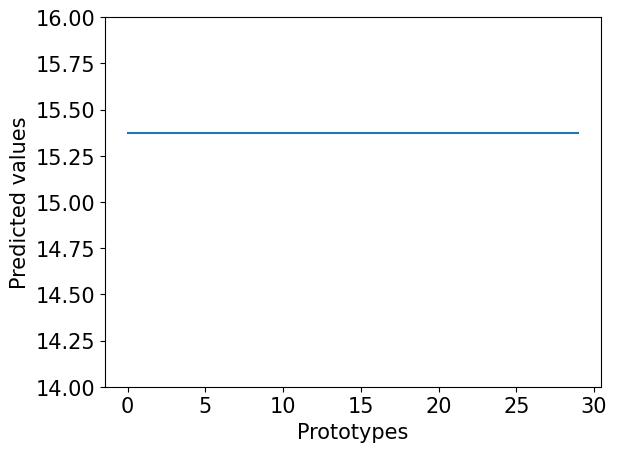

In [31]:
plt.plot(preds)
plt.ylim(14,16)
plt.ylabel('Predicted values')
plt.xlabel('Prototypes')

In [12]:
plt.plot([5, 15, 20, 30, 50], results_q)
plt.ylabel('Optimization target')
plt.xlabel('Number of prototypes')

NameError: name 'results_q' is not defined

In [14]:
radar_data=[
    [
        'Long1', 'Lat1', 'Temp1', 'Dir1', 'Speed1', 'Dist1',
        'Long2', 'Lat2', 'Temp2', 'Dir2', 'Speed2', 'Dist2',
        'Long3', 'Lat3', 'Temp3', 'Dir3', 'Speed3', 'Dist3',
        'Long4', 'Lat4', 'Temp4', 'Dir4', 'Speed4', 'Dist4',
        'Long5', 'Lat5', 'Temp5', 'Dir5', 'Speed5', 'Dist5',
        'Long6', 'Lat6', 'Temp6', 'Dir6', 'Speed6', 'Dist6',
        'Bias',
    ],
    ('Prototypes',ts_prototypes),
    ('Conclusion parameters',ts_weights)
]

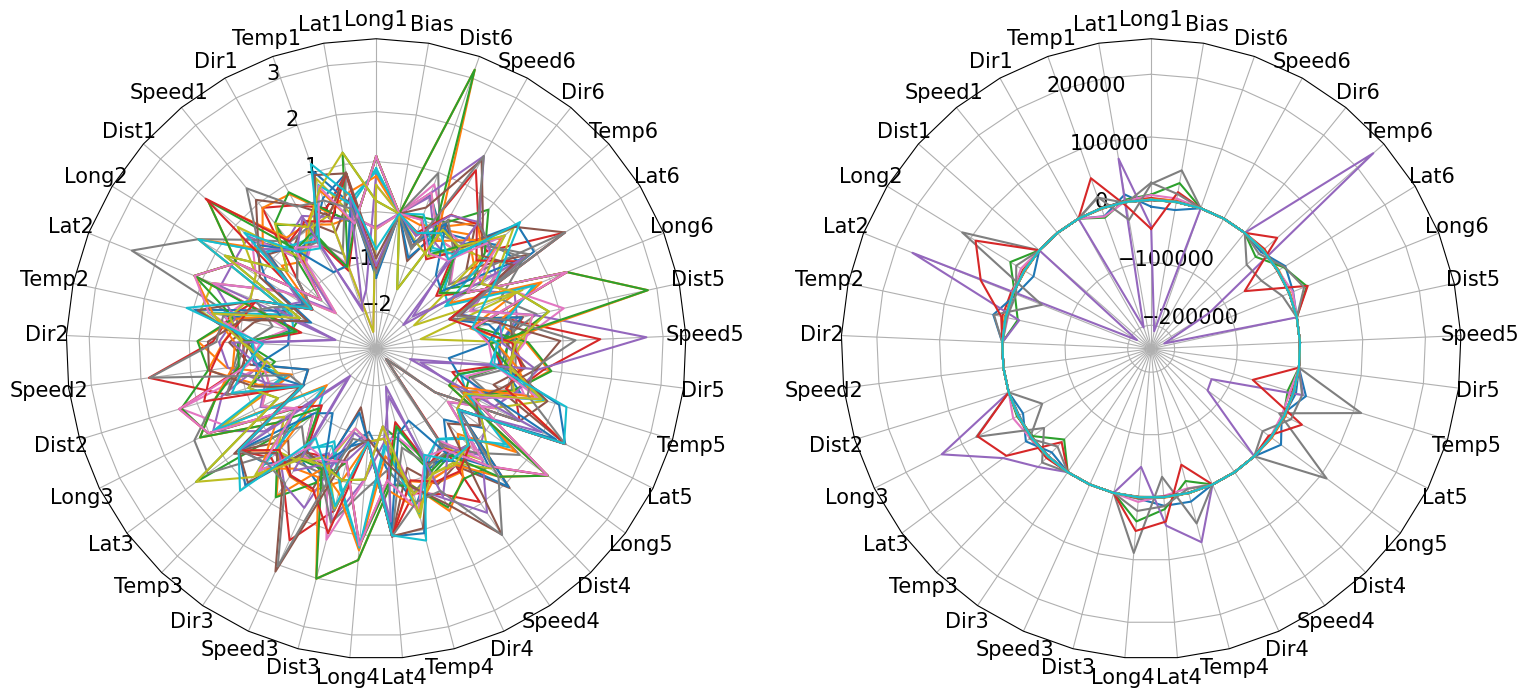

In [15]:
plt.rcParams.update({'font.size': 15})
N = 37
theta = radar_factory(N, frame='polygon')

data = radar_data
spoke_labels = data.pop(0)
#ts_prototypes
fig, axs = plt.subplots(figsize=(18, 9), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
#     ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#                  horizontalalignment='center', verticalalignment='center')
    for d in case_data:
        ax.plot(theta, d)
        #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs.legend(labels, loc=(0.9, .95),
#                           labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, 'Visualization of optimial TS rule-based model c=30',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.show()

In [7]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [60]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y, number_of_rules):
    
    ts_model = TsModel.TsModel(number_of_rules=number_of_rules, early_end_threshold=1e-8, fuzzification_coefficient=1.2)
    _, rmse_train, _ = ts_model.fit(train_x,train_y)
    
    y_hat_validation = ts_model.predict(validation_x)
    rmse_validation = mean_squared_error(validation_y, y_hat_validation,squared=False)

    return rmse_train, rmse_validation

In [61]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1]

#range_of_m = [2.2, 2.3, 2.4, 2.5,2.8, 3, 3.2]
range_of_rules = [2, 5, 8, 9, 10, 12, 15, 18, 20, 25, 30, 35, 50, 80]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers
training_results = []
test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    # Station data is generated already, only need to train the model
    flatten_train_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/1x.csv", index_col=0).to_numpy()
    flatten_train_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/1y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

    # Test data should still need to be generated
    flatten_test_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/1x_test.csv", index_col=0).to_numpy()
    flatten_test_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/1y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

    for hyperparameter_value in hyper_parameter_to_test_values:
 
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        test_results_fold = []
            
        for i in range(0, number_of_folds):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
    
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            norm_flatten_train_x, norm_flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(norm_flatten_train_x, flatten_train_y, norm_flatten_test_x , flatten_test_y, hyperparameter_value)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            test_results_fold.append({'fcm_test' : fcm_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        test_results.append(test_results_fold)        

In [62]:
do_experiment(range_of_rules)

Currently running fold 0 for 2 stations
FCM training RMSE: 7.136835995242361
Currently running fold 1 for 2 stations
FCM training RMSE: 7.13683599524168
Currently running fold 2 for 2 stations
FCM training RMSE: 7.136835995241319
Currently running fold 3 for 2 stations
FCM training RMSE: 7.136835995241454
Currently running fold 4 for 2 stations
FCM training RMSE: 7.136835995241491
Currently running fold 5 for 2 stations
FCM training RMSE: 7.136835995241679
Currently running fold 6 for 2 stations
FCM training RMSE: 7.1368359952414036
Currently running fold 7 for 2 stations
FCM training RMSE: 7.1368359952413485
Currently running fold 8 for 2 stations
FCM training RMSE: 7.136835995241008
Currently running fold 9 for 2 stations
FCM training RMSE: 7.136835995241355
Currently running fold 0 for 5 stations
FCM training RMSE: 6.957703456187714
Currently running fold 1 for 5 stations
FCM training RMSE: 6.957703456187708
Currently running fold 2 for 5 stations
FCM training RMSE: 6.89899945027826

FCM training RMSE: 6.385080705308213
Currently running fold 6 for 30 stations
FCM training RMSE: 6.389341317685194
Currently running fold 7 for 30 stations
FCM training RMSE: 6.408644174735825
Currently running fold 8 for 30 stations
FCM training RMSE: 6.418079904005969
Currently running fold 9 for 30 stations
FCM training RMSE: 6.410993913743537
Currently running fold 0 for 35 stations
FCM training RMSE: 6.355638243515941
Currently running fold 1 for 35 stations
FCM training RMSE: 6.35627650425942
Currently running fold 2 for 35 stations
FCM training RMSE: 6.376836040178984
Currently running fold 3 for 35 stations
FCM training RMSE: 6.349781536019219
Currently running fold 4 for 35 stations
FCM training RMSE: 6.3874985389743175
Currently running fold 5 for 35 stations
FCM training RMSE: 6.365922517575038
Currently running fold 6 for 35 stations
FCM training RMSE: 6.37397902989141
Currently running fold 7 for 35 stations
FCM training RMSE: 6.388311504519216
Currently running fold 8 for

In [70]:
# training_results_fcm_ruleopt = training_results
# test_results_fcm_ruleopt = test_results

# %store training_results_fcm_ruleopt
# %store test_results_fcm_ruleopt

# %store -r training_results
# %store -r test_results

# %store -r training_results_kmeans
# %store -r test_results_kmeans

Stored 'training_results_fcm_ruleopt' (list)
Stored 'test_results_fcm_ruleopt' (list)


In [57]:
#training_results_fcm_m_finetune = training_results
# %store training_results_fcm_m_finetune


Stored 'training_results_fcm_m_finetune' (list)


7.13683599524151 ± 3.3685236521170335e-13
6.943491658207047 ± 0.030780389084172004
6.782916765689132 ± 0.03230569743081068
6.761598257926643 ± 0.016734644804109793
6.7343960598597405 ± 0.024923070807114946
6.709835785771534 ± 0.03713487165155816
6.67084705287367 ± 0.028644010615942506
6.59210763821055 ± 0.02733122005129337
6.54717768926956 ± 0.023793197762895246
6.471000042382134 ± 0.02017056465619452
6.411264854299901 ± 0.015452632054197366
6.370921885123886 ± 0.018653733008772842
6.302339514818472 ± 0.014918598979952803
6.183723869565759 ± 0.010047399217006885


Text(0, 0.5, 'RMSE wind speed')

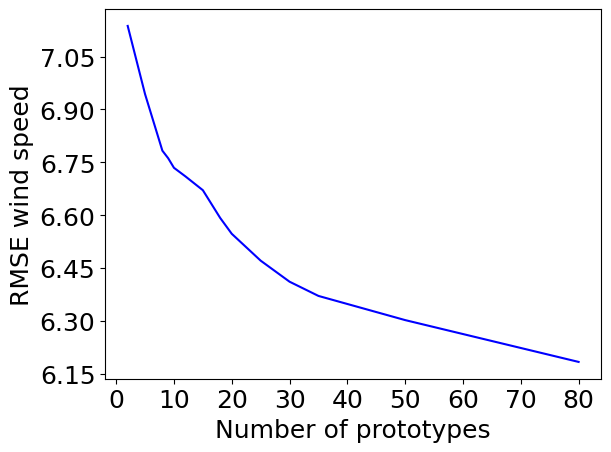

In [69]:
x_axis =  range_of_rules
fcm_train_plot= []

for exp in training_results_fcm_ruleopt:
    rmse = np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d])
    std = np.std([d['fcm_train'] for d in exp if 'fcm_train' in d])
    print(f'{rmse} ± {std}')
    fcm_train_plot.append(rmse)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')

#plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of prototypes')
plt.ylabel('RMSE wind speed')


6.440358895382064 ± 0.020180801328717357
6.4142868420009105 ± 0.012702070173616822
6.418524561808708 ± 0.016012139521487376
6.445766899292694 ± 0.018696757130669955
6.43562985133225 ± 0.005185398830450837
6.4640421133657044 ± 0.017117786322265034
6.535080656143917 ± 0.007329220825671588
6.661583913350219 ± 0.030086251284062445
6.735187023514437 ± 0.019199365251915637
6.764065529023893 ± 0.012287554976322895
6.798572971693622 ± 0.0035934666060530433
6.78499223862899 ± 0.013605465559661028
6.9977355970419435 ± 0.0003597764531977508
7.161326965181816 ± 2.166395321211348e-07
7.231147449723212 ± 1.8630587706705477e-15
7.231148172116167 ± 2.1671788568156107e-06
7.23115603854051 ± 2.5623727568224213e-05
7.231158475279625 ± 2.5376371972721568e-05


Text(0, 0.5, 'RMSE wind speed')

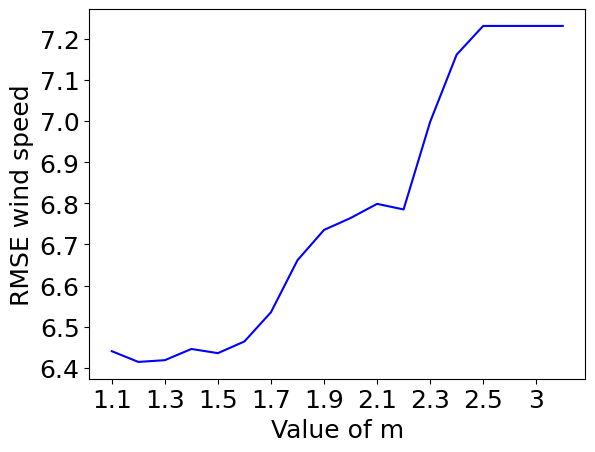

In [67]:
x_axis =  ['1.1','1.2','1.3','1.4', '1.5','1.6','1.7', '1.8','1.9','2','2.1','2.2', '2.3', '2.4', '2.5','2.8', '3', '3.2']
fcm_train_plot= []

for exp in training_results_fcm_m_finetune:
    rmse = np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d])
    std = np.std([d['fcm_train'] for d in exp if 'fcm_train' in d])
    print(f'{rmse} ± {std}')
    fcm_train_plot.append(rmse)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')

#plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Value of m')
plt.ylabel('RMSE wind speed')


Text(0, 0.5, 'RMSE wind speed')

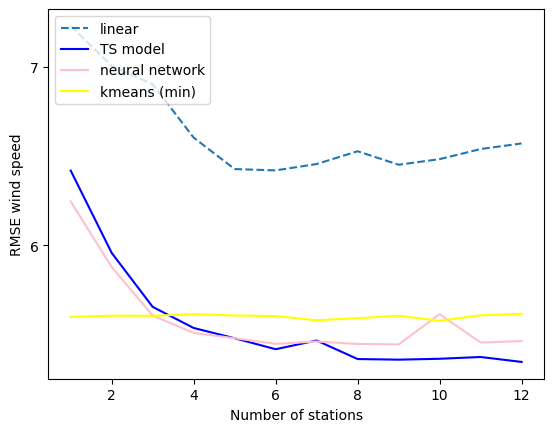

In [47]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
kmeans_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
    
for exp in training_results_fcm_mopt:
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
        
for exp in training_results_kmeans:
     kmeans_train_plot.append(np.min([d['kmeans_train'] for d in exp if 'kmeans_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

# for exp in training_results_full_feature:
#     print('exp')
#     print(f"{np.round(np.mean([d['kmeans_train'] for d in exp if 'kmeans_train' in d]), 4)}±{np.round(np.std([d['kmeans_train'] for d in exp if 'kmeans_train' in d]),4)}")
 

In [22]:
# gpr_test_results=[]
# gpr_test_results.append({'gpr_test': 124.28245462517742})
# gpr_test_results.append({'gpr_test': 8.098453253845573})
# gpr_test_results.append({'gpr_test': 7.383525517000387})
# gpr_test_results.append({'gpr_test': 7.266723098591452})
# gpr_test_results.append({'gpr_test': 7.269252212307546})
# gpr_test_results.append({'gpr_test': 7.246991937014375})
# gpr_test_results.append({'gpr_test': 7.127975366729728})
# gpr_test_results.append({'gpr_test': 7.125519317911804})
# gpr_test_results.append({'gpr_test': 7.096831995981307})
# gpr_test_results.append({'gpr_test': 7.09245097390881})
# gpr_test_results.append({'gpr_test': 7.123352723065476})
# gpr_test_results.append({'gpr_test': 7.136209476848252})

Text(0, 0.5, 'RMSE wind speed')

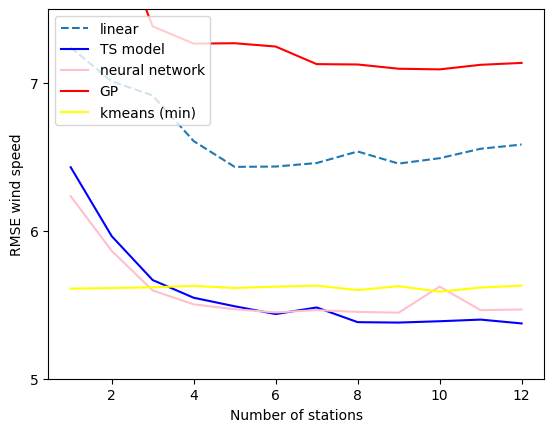

In [46]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []
kmeans_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(exp['gpr_test'])
    
for exp in test_results_fcm_mopt:
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
        
for exp in test_results_kmeans:
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_test_plot, label='GP', c='red')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
plt.ylim(5,7.5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

# for exp in test_results_full_feature:
#     print('exp')
#     print(f"{np.round(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}±{np.round(np.std([d['kmeans_test'] for d in exp if 'kmeans_test' in d]),4)}")
 

In [120]:
kmeans_avg = []
for exp in test_results_full_feature:
    kmeans_avg.append(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))

print(f"{np.mean(kmeans_avg)}±{np.round(np.std(kmeans_avg),4)}")
 

35333916409.24774±69136985570.5394
